In [67]:
import os
from typing import Any

import numpy as np
import time

# from torch.utilities.types import STEP_OUTPUT
from sklearn.svm import SVC
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

In [68]:
assets_path = "."
train_embeddings = os.path.realpath(assets_path + "/assets/annotated-corpus/train_embeddings.tsv")
test_embeddings = os.path.realpath(assets_path + "/assets/annotated-corpus/test_embeddings.tsv")
topics = os.listdir(os.path.realpath(assets_path + "/assets/annotated-corpus/train"))

In [69]:
def prepare_dataset(filename):
    x_raw = []
    y_raw = []
    with open(filename) as f:
        lines = f.readlines()[:-1]
        for line in lines:
            y_raw.append(topics.index(line.split("\t", 1)[0].split("\\")[0]))
            x_raw.append(list(map(float, line.split("\t", 1)[1].split("\t"))))

    return np.array(x_raw), np.array(y_raw)

In [70]:
x_train, y_train = prepare_dataset(train_embeddings)
x_test, y_test = prepare_dataset(test_embeddings)

In [71]:
x_train

array([[ 0.65454792, -0.55473193, -1.14327075, ..., -0.63646512,
        -1.5511429 ,  0.55359994],
       [-0.76894362, -0.76025113, -1.06214342, ...,  0.85721762,
        -0.10778847, -0.28209683],
       [ 0.20580587, -0.56083068, -0.71416801, ...,  0.22655786,
        -1.11671368,  0.35277561],
       ...,
       [ 0.0358307 ,  0.30800404, -1.09508474, ...,  0.51700093,
        -1.42208699, -0.71201518],
       [ 0.51561248,  0.41605808,  0.24751022, ...,  0.26934585,
        -0.13434458,  0.1042229 ],
       [-1.02319924, -0.25457948,  0.88130147, ..., -0.62886841,
        -0.60324107,  1.36890092]])

In [91]:
y_train

array([0, 0, 0, ..., 1, 1, 1])

In [72]:
clf1 = SVC()

In [73]:
clf1.fit(x_train, y_train)

SVC()

In [12]:
preds = clf1.predict(x_test)

In [13]:
def calculate_raw_metrics(pred, gt):
    metrics_dict = {}
    for i in gt:
        if i not in metrics_dict.keys():
             metrics_dict[i] = {"tp": 0, "fp": 0, "tn": 0, "fn": 0}
    for i in range(pred.shape[0]):
        if pred[i] == gt[i]:
            metrics_dict[gt[i]]["tp"] += 1
            for j in metrics_dict.keys():
                if j != gt[i]:
                    metrics_dict[j]["tn"] += 1
        else:
            metrics_dict[pred[i]]["fp"] += 1
            metrics_dict[gt[i]]["fn"] += 1

    return metrics_dict


In [14]:
def calculate_metrics(pred, gt):
    raw_dict = calculate_raw_metrics(pred, gt)
    metrics_dict = {}
    global_tp = 0
    global_fp = 0
    global_tn = 0
    global_fn = 0
    metrics_dict["precision_macro"] = 0
    metrics_dict["recall_macro"] = 0
    metrics_dict["f1_macro"] = 0
    for i in raw_dict.keys():
        metrics_dict[i] = {}
        metrics_dict[i]["precision"] = raw_dict[i]["tp"] / (raw_dict[i]["tp"] + raw_dict[i]["fp"])
        metrics_dict[i]["recall"] = raw_dict[i]["tp"] / (raw_dict[i]["tp"] + raw_dict[i]["fn"])
        metrics_dict[i]["f1"] = 2 * raw_dict[i]["tp"] / (2 * raw_dict[i]["tp"] + raw_dict[i]["fp"] + raw_dict[i]["fn"])
        global_tp += raw_dict[i]["tp"]
        global_tn += raw_dict[i]["tn"]
        global_fn += raw_dict[i]["fn"]
        global_fp += raw_dict[i]["fp"]
        metrics_dict["precision_macro"] += metrics_dict[i]["precision"] / len(raw_dict.keys())
        metrics_dict["recall_macro"] += metrics_dict[i]["recall"] / len(raw_dict.keys())
        metrics_dict["f1_macro"] += metrics_dict[i]["f1"] / len(raw_dict.keys())
    metrics_dict["precision_micro"] = global_tp / (global_tp + global_fp)
    metrics_dict["recall_micro"] = global_tp / (global_tp + global_fn)
    metrics_dict["f1_micro"] = 2 * global_tp / (2 * global_tp + global_fn + global_fp)
    metrics_dict["accuracy"] = global_tp / gt.shape[0]
    return metrics_dict

In [15]:
def reference_metrics(pred, gt):
    print("Precision:", precision_score(gt, pred, average=None))
    print("Recall:", recall_score(gt, pred, average=None))
    print("F1:", f1_score(gt, pred, average=None))
    print("Precision macro:", precision_score(gt, pred, average="macro"))
    print("Recall macro:", recall_score(gt, pred, average="macro"))
    print("F1 macro:", f1_score(gt, pred, average="macro"))
    print("Precision micro:", precision_score(gt, pred, average="micro"))
    print("Recall micro:", recall_score(gt, pred, average="micro"))
    print("F1 micro:", f1_score(gt, pred, average="micro"))
    print("Accuracy:", accuracy_score(gt, pred))

In [77]:
calculate_raw_metrics(preds, y_test)

{0: {'tp': 1684, 'fp': 133, 'tn': 5164, 'fn': 216},
 3: {'tp': 1844, 'fp': 122, 'tn': 5004, 'fn': 56},
 2: {'tp': 1641, 'fp': 256, 'tn': 5207, 'fn': 259},
 1: {'tp': 1679, 'fp': 240, 'tn': 5169, 'fn': 220}}

In [92]:
calculate_metrics(preds, y_test)

{'precision_macro': 0.9011831071693989,
 'recall_macro': 0.9011689670463678,
 'f1_macro': 0.9009873329988283,
 0: {'precision': 0.9268024215740231,
  'recall': 0.8863157894736842,
  'f1': 0.906107075598601},
 3: {'precision': 0.9379450661241099,
  'recall': 0.9705263157894737,
  'f1': 0.9539575788929125},
 2: {'precision': 0.8650500790722193,
  'recall': 0.8636842105263158,
  'f1': 0.8643666052146431},
 1: {'precision': 0.8749348619072433,
  'recall': 0.8841495523959979,
  'f1': 0.8795180722891566},
 'precision_micro': 0.9011712067377287,
 'recall_micro': 0.9011712067377287,
 'f1_micro': 0.9011712067377287,
 'accuracy': 0.9011712067377287}

In [93]:
reference_metrics(preds, y_test)

Precision: [0.92680242 0.87493486 0.86505008 0.93794507]
Recall: [0.88631579 0.88414955 0.86368421 0.97052632]
F1: [0.90610708 0.87951807 0.86436661 0.95395758]
Precision macro: 0.901183107169399
Recall macro: 0.901168967046368
F1 macro: 0.9009873329988284
Precision micro: 0.9011712067377287
Recall micro: 0.9011712067377287
F1 micro: 0.9011712067377287
Accuracy: 0.9011712067377287


In [18]:
def train_evaluate_model(model, x_train, y_train, x_test, y_test):
    t_begin = time.time()
    model.fit(x_train, y_train)
    t_end = time.time()
    preds = model.predict(x_test)
    metrics = calculate_metrics(preds, y_test)
    print("Precision macro:", metrics["precision_macro"])
    print("Recall macro:", metrics["recall_macro"])
    print("F1 macro:", metrics["f1_macro"])
    print("Precision micro:", metrics["precision_micro"])
    print("Recall micro:", metrics["recall_micro"])
    print("F1 micro:", metrics["f1_micro"])
    print("Accuracy:", metrics["accuracy"])
    print("Time:", t_end - t_begin)
    return model

In [19]:
svm_linear = train_evaluate_model(SVC(kernel="linear"), x_train, y_train, x_test, y_test)

Precision macro: 0.8619175100225498
Recall macro: 0.8620835758432416
F1 macro: 0.8619656397321647
Precision micro: 0.862087116725885
Recall micro: 0.862087116725885
F1 micro: 0.862087116725885
Accuracy: 0.862087116725885
Time: 1352.0472218990326


In [20]:
svm_poly = train_evaluate_model(SVC(kernel="poly"), x_train, y_train, x_test, y_test)

Precision macro: 0.8969705232754505
Recall macro: 0.8961705606829079
F1 macro: 0.8957714040742218
Precision micro: 0.8961705487564153
Recall micro: 0.8961705487564153
F1 micro: 0.8961705487564153
Accuracy: 0.8961705487564153
Time: 371.8358950614929


In [21]:
svm_rbf = train_evaluate_model(SVC(kernel="rbf"), x_train, y_train, x_test, y_test)

Precision macro: 0.9011831071693989
Recall macro: 0.9011689670463678
F1 macro: 0.9009873329988283
Precision micro: 0.9011712067377287
Recall micro: 0.9011712067377287
F1 micro: 0.9011712067377287
Accuracy: 0.9011712067377287
Time: 290.9645938873291


In [23]:
svm_sigmoid = train_evaluate_model(SVC(kernel="sigmoid"), x_train, y_train, x_test, y_test)

Precision macro: 0.7634053801976474
Recall macro: 0.7598289958704028
F1 macro: 0.7608789227225814
Precision micro: 0.759836820634294
Recall micro: 0.759836820634294
F1 micro: 0.759836820634294
Accuracy: 0.759836820634294
Time: 333.1193940639496


In [51]:
train_evaluate_model(SVC(kernel="rbf"), x_train, y_train, x_test, y_test)

Precision macro: 0.9011831071693989
Recall macro: 0.9011689670463678
F1 macro: 0.9009873329988283
Precision micro: 0.9011712067377287
Recall micro: 0.9011712067377287
F1 micro: 0.9011712067377287
Accuracy: 0.9011712067377287
Time: 311.547150850296


SVC()

In [52]:
perm = np.random.permutation(len(x_train))

In [87]:
x_train[perm][:8000]

array([[ 0.40495352, -0.32568623,  0.23063304, ...,  1.25628974,
        -0.31392969, -0.27183271],
       [ 0.08484635, -0.10756095, -0.88286668, ...,  0.65038643,
         1.47233067, -0.351867  ],
       [ 0.28515767, -0.85939251, -1.43696873, ...,  0.42882515,
        -1.27666597,  0.4449418 ],
       ...,
       [ 0.38952033, -0.3630528 , -0.31177461, ...,  0.29911455,
        -0.50473479, -0.35212736],
       [ 0.51884848, -0.11648473, -0.59967227, ...,  1.07034619,
        -0.15403078,  1.26596488],
       [ 0.54830898, -0.22313712,  0.18294551, ...,  0.42278512,
        -0.45646198, -0.50197296]])

In [53]:
train_evaluate_model(SVC(kernel="rbf"), x_train[perm][:8000], y_train[perm][:8000], x_test, y_test)

Precision macro: 0.8791837323260032
Recall macro: 0.8795866245392312
F1 macro: 0.8793005686078061
Precision micro: 0.8795894196604817
Recall micro: 0.8795894196604817
F1 micro: 0.8795894196604817
Accuracy: 0.8795894196604817
Time: 1.3431339263916016


SVC()

In [54]:
train_evaluate_model(SVC(kernel="rbf"), x_train[perm][:6000], y_train[perm][:6000], x_test, y_test)

Precision macro: 0.8717901043166745
Recall macro: 0.8722168177156953
F1 macro: 0.8719555322830532
Precision micro: 0.8722200289511778
Recall micro: 0.8722200289511778
F1 micro: 0.8722200289511778
Accuracy: 0.8722200289511778
Time: 0.6331350803375244


SVC()

In [55]:
train_evaluate_model(SVC(kernel="rbf"), x_train[perm][:2000], y_train[perm][:2000], x_test, y_test)

Precision macro: 0.8575084677740716
Recall macro: 0.8582659848673817
F1 macro: 0.8577302505781041
Precision micro: 0.8582708251085669
Recall micro: 0.8582708251085669
F1 micro: 0.8582708251085669
Accuracy: 0.8582708251085669
Time: 0.09325718879699707


SVC()

In [57]:
from sklearn.decomposition import PCA

pca = PCA(n_components=50)
pca.fit(x_train)

PCA(n_components=50)

In [58]:
train_evaluate_model(SVC(kernel="rbf"), pca.transform(x_train), y_train, pca.transform(x_test), y_test)

Precision macro: 0.8972624053906225
Recall macro: 0.8970899503894016
F1 macro: 0.8969816391935157
Precision micro: 0.8970917225950783
Recall micro: 0.8970917225950783
F1 micro: 0.8970917225950783
Accuracy: 0.8970917225950783
Time: 143.76766300201416


SVC()

In [59]:
pca_2 = PCA(n_components=2)

In [60]:
draw_data = pca_2.fit_transform(x_train[perm][:500])

In [61]:
draw_data

array([[ 2.17959592, -2.25469878],
       [-3.22674724, -0.74411061],
       [-3.13653279,  4.06222316],
       [-2.36814008, -3.09923048],
       [-0.06243157, -0.67191104],
       [ 1.72308032, -2.67008536],
       [ 2.90613353, -0.54038126],
       [-2.56456526,  0.32207932],
       [ 0.03486202,  2.01449329],
       [-2.41898114,  2.93251404],
       [ 2.31336474,  1.1882966 ],
       [ 2.94066572,  0.21379868],
       [-1.39534527, -4.34120421],
       [ 3.35593048,  1.21617962],
       [ 1.93064058,  1.09130924],
       [-4.38876618,  2.35251543],
       [-2.41423587, -1.61779622],
       [ 0.86808583,  0.44604615],
       [-1.43056237,  3.24953783],
       [-0.92395754, -2.47643364],
       [-1.60460184,  1.70775075],
       [-3.03972021, -4.45647751],
       [ 1.71093727, -1.98883072],
       [ 2.93168629, -0.62345309],
       [ 2.67874013, -0.68700858],
       [ 4.30794856, -1.48212714],
       [-3.23237246, -0.10274116],
       [ 3.7900773 ,  0.48751164],
       [ 2.77443164,

In [62]:
import matplotlib.pyplot as plt

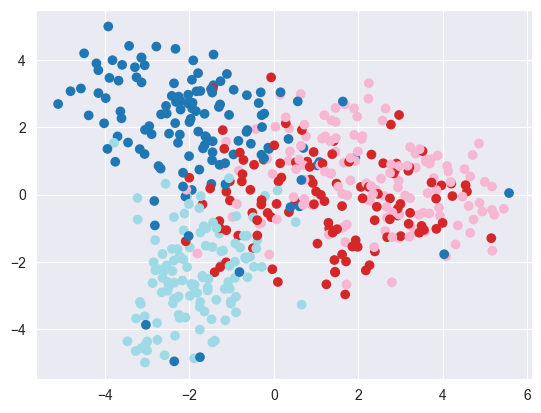

In [63]:
plt.scatter(draw_data[:, 0], draw_data[:, 1], c=y_train[perm][:500], cmap="tab20")

In [64]:
x_train_extended = np.concatenate((x_train, np.sin(x_train), np.cos(x_train)), axis=1)
x_test_extended = np.concatenate((x_test, np.sin(x_test), np.cos(x_test)), axis=1)

In [65]:
x_train_extended.shape

(119999, 300)

In [66]:
train_evaluate_model(SVC(kernel="rbf"), x_train_extended, y_train, x_test_extended, y_test)

Precision macro: 0.8965596696425995
Recall macro: 0.8965633574457471
F1 macro: 0.8963809463820572
Precision micro: 0.8965653375444137
Recall micro: 0.8965653375444137
F1 micro: 0.8965653375444137
Accuracy: 0.8965653375444137
Time: 745.8452501296997


SVC()